In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn 
import plotly.express as px

# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке.
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

In [ ]:
df = pd.read_csv('amazon_co-ecommerce_sample.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

df.head()


,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
0,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
1,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
2,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
3,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
4,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...


In [ ]:
df.sample()

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
9217,Paul Lamond,£7.99,10 new,1,5.0,5.0 out of 5 stars,Games > Dominoes & Tile Games


## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

In [ ]:
number_of_spaces=df.isnull().sum()
all_cels=df.size
print(number_of_spaces)
all_num_of_spaces=number_of_spaces.sum()
print(all_num_of_spaces)
print("Percent of space cells:")
print(all_num_of_spaces/all_cels)

manufacturer                           7
price                               1435
number_available_in_stock           2500
number_of_reviews                     18
number_of_answered_questions         765
average_review_rating                 18
amazon_category_and_sub_category     690
dtype: int64
5433
Percent of space cells:
0.07761428571428572


В теории,мы можем удалить колонку, где больше всего(2500>50%) незаполненных клеток, т.к. скорее всего данный признак не особо будет влиять на что-либо.



In [ ]:
df = df.drop(columns = ['number_available_in_stock'])



In [ ]:
print(df.isnull().sum().sum())
print(df.isnull().sum())


2933
manufacturer                           7
price                               1435
number_of_reviews                     18
number_of_answered_questions         765
average_review_rating                 18
amazon_category_and_sub_category     690
dtype: int64


## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.

In [ ]:

df.head()

,manufacturer,price,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
0,Hornby,£3.42,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
1,FunkyBuys,£16.99,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
2,ccf,£9.99,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
3,Hornby,£39.99,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
4,Hornby,£32.19,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...


In [ ]:
df.sample()

,manufacturer,price,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
2847,farmyard party,£4.27,1,NaN,5.0 out of 5 stars,Party Supplies > Decorations > Balloons


Хочется перевести многие данные, содержащие в себе строки и числа с плавающей запятой, к типу float. 

In [ ]:

def to_float_string(string):
   string = string.replace(',', '')#для правильной интерпретации чисел с запятыми,отделяющие целочисленные разряды(тысячи и т.д.)
   return float(string)

    
    


Существуют особенности перевода цен в float - может быть Nan вместо цены или указан диапазон =>  все эти варианты надо отработать.

In [ ]:

for a in range(0, len(df.price)):
  if (isinstance(df.price[a], str)):
    if (len(df.price[a].split('-')) == 1):
      df.price[a] = to_float_string(df.price[a][1:])
    else:
      df.price[a] = (to_float_string(df.price[a].split('- ')[0][1:]) + to_float_string(df.price[a].split('- ')[1][1:]))/2
  else:
    df.price[a] = 0

<ipython-input-616-13e528f696c8>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-616-13e528f696c8>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-616-13e528f696c8>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Сходным образом преобразуем и данные в average_review_rating

In [ ]:
for a in range(0, len(df.average_review_rating)):
  if (isinstance(df.average_review_rating[a], str)):
    df.average_review_rating[a] = to_float_string(df.average_review_rating[a].split()[0])
  else:
    df.average_review_rating[a] = 0

<ipython-input-617-9d17a782bb04>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-617-9d17a782bb04>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Производители - очень хорошие люди, но столбец с ними нам не нужен в датасете - удалим 


In [ ]:
df = df.drop(columns = ['manufacturer'])

Закодируем информацию о категориях и факторизуем ее

In [ ]:
nwdf = df.amazon_category_and_sub_category.str.split(' > ', expand=True) 
nwdf.columns=['sub_category_0','sub_category_1','sub_category_2', 'sub_category_3', 'sub_category_4']#Новый df с закодированными категориям

fin_df = pd.concat([df,nwdf], axis = 1) 
fin_df =fin_df.drop(columns = ['amazon_category_and_sub_category'], axis = 1) #Удаляем старый столбец

df = fin_df
df.sub_category_0 = pd.factorize(df.sub_category_0)[0] + 1
df.sub_category_1 = pd.factorize(df.sub_category_1)[0] + 1
df.sub_category_2 = pd.factorize(df.sub_category_2)[0] + 1
df.sub_category_3 = pd.factorize(df.sub_category_3)[0] + 1
df.sub_category_4 = pd.factorize(df.sub_category_4)[0] + 1

In [ ]:
df.sample()

,price,number_of_reviews,number_of_answered_questions,average_review_rating,sub_category_0,sub_category_1,sub_category_2,sub_category_3,sub_category_4
834,0,1,1.0,5.0,12,24,10,12,0


Подчистим пропуски и преобразуем во float незатронутый number_of_reviews

In [ ]:
df = df.fillna(0)

In [ ]:
for a in range(0, len(df.price)):
  if (isinstance(df.number_of_reviews[a], str)):
    df.number_of_reviews[a] = to_float_string(df.number_of_reviews[a])
  if (isinstance(df.number_of_answered_questions[a], str)):
    df.number_of_answered_questions[a] = to_float_string(df.number_of_answered_questions[a])

<ipython-input-622-7e8ccc25ddc0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.head()

,price,number_of_reviews,number_of_answered_questions,average_review_rating,sub_category_0,sub_category_1,sub_category_2,sub_category_3,sub_category_4
0,3.42,15.0,1.0,4.9,1,1,1,1,0
1,16.99,2.0,1.0,4.5,1,1,1,1,0
2,9.99,17.0,2.0,3.9,1,1,1,1,0
3,39.99,1.0,2.0,5.0,1,1,1,1,0
4,32.19,3.0,2.0,4.7,1,1,1,1,0


# Обучение модели (3 балла)

In [ ]:
from sklearn.model_selection import train_test_split
X, y = df.drop(columns=['price']), df["price"]

Xtrain, Xtest, Ytrain, Ytest=train_test_split(X, y, train_size=0.7)

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error,r2_score


dummy_regres = DummyRegressor()
dummy_regers=dummy_regres.fit(Xtrain, Ytrain)

In [ ]:
yprediction=dummy_regres.predict(Xtest)
mse=mean_squared_error(Ytest,yprediction)
rmse=np.sqrt(mean_squared_error(Ytest,yprediction))
r2=r2_score(Ytest,yprediction)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2SCORE:",r2)

MSE: 23338.157974560116
RMSE: 152.7683146943767
R2SCORE: -0.00010788483577250929


## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.

In [ ]:
from sklearn.tree import DecisionTreeRegressor


dtree = DecisionTreeRegressor()
dtree.fit(Xtrain, Ytrain)
yprediction=dtree.predict(Xtest)

In [ ]:
mse=mean_squared_error(Ytest,yprediction)
rmse=np.sqrt(mean_squared_error(Ytest,yprediction))
r2=r2_score(Ytest,yprediction)
print("R2SCORE:",r2)
print("MSE:",mse)
print("RMSE:",rmse)

R2SCORE: -0.10101300549118308
MSE: 25692.84358598765
RMSE: 160.2898736227203


Качество ухудшилось по сравнению с базовой(dummy) моделью

## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

In [ ]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()
linear.fit(Xtrain, Ytrain)
y_pred = linear.predict(Xtest)

yprediction=linear.predict(Xtest)
mse=mean_squared_error(Ytest,yprediction)
rmse=np.sqrt(mean_squared_error(Ytest,yprediction))
r2=r2_score(Ytest,yprediction)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2SCORE:",r2)

MSE: 23301.866049616085
RMSE: 152.64948755110868
R2SCORE: 0.0014473296045428574


Лучше дерева, но все еще хуже dummy модели

# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

In [ ]:
import seaborn as sns

In [ ]:

def PFC (parameter: str, values: list, trX = Xtrain, tsX = Xtest, trY = Ytrain, tsY = Ytest):
    trainCurve = []
    testCurve = []
    for value in values:
        treeModel = DecisionTreeRegressor(**{parameter: value})
        treeModel.fit(trX, trY)
        predictTrainY = treeModel.predict(trX)
        predictTestY =  treeModel.predict(tsX)
        trainCurve.append(r2_score(trY, predictTrainY))
        testCurve.append(r2_score(tsY, predictTestY))
    sns.lineplot(x=values, y=trainCurve, label='train')
    sns.lineplot(x=values, y=testCurve, label='test')

Построим графики 

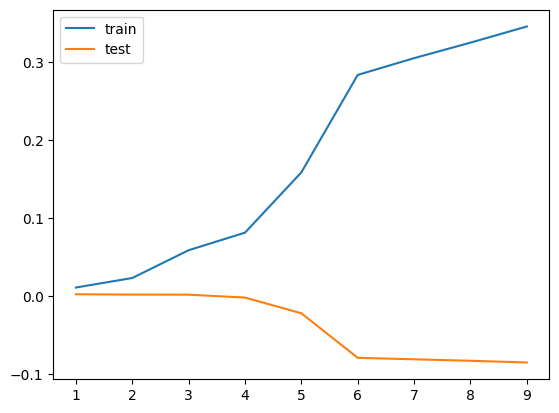

In [ ]:
PFC('max_depth', np.arange(1, 10))

Выберем тут 5

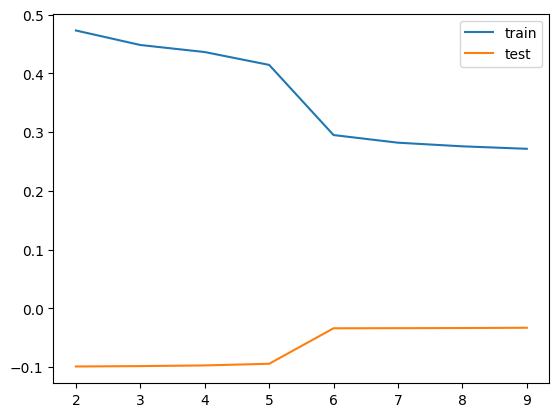

In [ ]:
PFC('min_samples_split', np.arange(2, 10))

Тут выберем 4

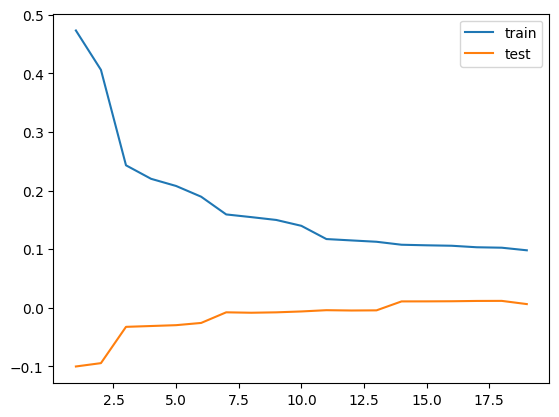

In [ ]:
PFC('min_samples_leaf', np.arange(1, 20, 1))

В 7 нет сильных перепадов. Строим дерево на основе параметров

In [ ]:
parameterTree = DecisionTreeRegressor(max_depth=5, min_samples_split=4, min_samples_leaf=7)
parameterTree.fit(Xtrain, Ytrain)
predictY = parameterTree.predict(Xtest)

MSE =  mean_squared_error(Ytest, predictY)
RMSE = np.sqrt(MSE)
R2 = r2_score(Ytest, predictY)

print("MSE:",mse)
print("RMSE:",rmse)
print("R2SCORE:",r2)

MSE: 23301.866049616085
RMSE: 152.64948755110868
R2SCORE: 0.0014473296045428574


Получилось гораздо лучше, чем с обычным деревом решений

# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [ ]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self.num_trees= num_trees
        self._samples_frac = 0.8
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]
    def fit(self, x, y: pd.Series):
        x = pd.DataFrame(x)
        y = y.reset_index(drop=True)
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=42)
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)
        return self

    def predict(self, x: pd.DataFrame):
        x = pd.DataFrame(x)
        res = []
        for i in range(self.num_trees):
          res.append(self._trees[i].predict(x))
        return sum(res) / len(res)

Обучим предлагаемый ассамбль и выведем значения для сравнения с теми, что были в прошлый раз



In [ ]:
ensam = EnsembleTreeRegressor()
ensam.fit(Xtrain, Ytrain)
ypredict = ensam.predict(Xtest)
mse=mean_squared_error(Ytest,yprediction)
rmse=np.sqrt(mean_squared_error(Ytest,yprediction))
r2=r2_score(Ytest,yprediction)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2SCORE:",r2)